In [12]:
import torch
from torch import nn
from IPython.display import clear_output

from src.encoder import Encoder, GPT2Encoder
from src.decoder import Decoder, GPT2Decoder
from src.graph_initialization import random_unidirectional_graph_maker, linear_unidirectional_graph_maker
from src.graphAN import GraphAttentionNetwork, BlockGenerator
from src.data_loader import validation
from src.tokenizer import Tokenizer
from src.GPT2 import GPT2_Block, GPT2
from matplotlib import pyplot as plt
from src.utils import moving_average, grad_norm
from torch.nn.utils import clip_grad_norm_
import pickle
import numpy as np
from termcolor import colored
from torch.nn import functional as F


import torch

from src.cellular_automata import CellularAutomata
from src.tokenizer import CharTokenizer

dir_path='shakespeare_data/'
input_file_path=dir_path+'input.txt'


#create the tokenizer
tokenizer=CharTokenizer(input_file_path)
print('tokenizer vocab size:', tokenizer.vocab_size)

# load the data
with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")


# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = tokenizer(train_data)
val_ids = tokenizer(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
torch.save(train_ids, dir_path+'train.bin')
torch.save(val_ids,   dir_path+'val.bin')


length of dataset in characters: 1,115,394
tokenizer vocab size: 65
length of dataset in characters: 1,115,394
train has 1,003,854 tokens
val has 111,540 tokens


In [13]:
from src.cellular_automata import DiffusionLoss
from src.encoder import NoiseEncoder


device = 'cpu'
#device = 'mps'  if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device

dK = 32
dV = 32
heads = 4
d_Embedding = dV*heads
intermediate_size=intermediate_size=d_Embedding


encoder = NoiseEncoder(d_Embedding, tokenizer, dropout=0, device=device)
decoder = Decoder(encoder)
block_generator = BlockGenerator(GPT2_Block, d_Embedding, dK, dV, heads, intermediate_size,
                                 dropout=0.1, split_size=2**10, device=device, rotary_encoding=True)

model = CellularAutomata(tokenizer, encoder, block_generator, decoder, n_blocks=2)
model.losses = []
model.validation_losses = []
model.tokens_seen=0

graph_maker = linear_unidirectional_graph_maker(64, device=device)

print(f'number of parameters:{model.n_parameters}')

lr = 1e-3
gamma = 0.99

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

from numpy.random import randint
def sample_shakespeare(data, lenght, starting_index=None):
    lenght=int(lenght)
    
    if starting_index is None:
        starting_index = randint(0, len(data)-lenght)

    if starting_index+lenght>=len(data):
        return data[starting_index:]    
    
    return data[starting_index:starting_index+lenght]

step_weight=None


loss_function=DiffusionLoss(decoder)

number of parameters:213248


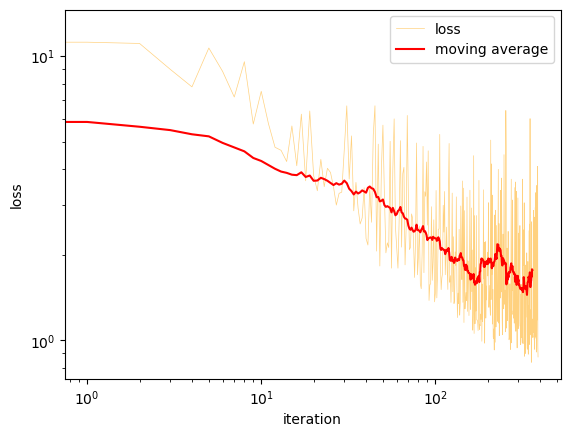

KeyboardInterrupt: 

In [14]:
#@title {vertical-output: true}
#@markdown # Training
#@markdown the loss function is cross entropy ❌🎲



n_epochs = int(2000)
model.train()
context_size=400
model.train()
n_steps=10

edge_index=graph_maker(context_size)

for i in range(n_epochs):
    noise=torch.rand(())
    
    target=sample_shakespeare(train_ids, context_size)

    prediction, clean_encoding, noise_encoding = encoder(target, noise)

    
    step_loss=torch.empty(n_steps, device=device)

    #do n steps 
    for j in range(n_steps):
        #make a forward pass
        prediction = model(prediction, edge_index)
        
        #compute loss
        step_loss[j]=loss_function(prediction, target, clean_encoding, noise_encoding)
        #apply step weight if given
        if step_weight is not None:
            step_loss[j]*=step_weight(j)

    #compute the total loss
    loss = step_loss.mean()
    best_possible_loss=F.cross_entropy(decoder(clean_encoding), target)


    model.logs={'noise':noise,
                'loss':loss.item(),
                'best_possible_loss':best_possible_loss.item(),
                'step_loss':step_loss.detach().cpu().numpy()}
    
    loss.backward()
    clip_grad_norm_(model.parameters(), 4*loss.item())


    optimizer.step()
    optimizer.zero_grad()  # reinitialize the gradient to zero
    model.tokens_seen+=context_size

    model.losses.append(loss.item())

    logging_interval=30
    if i%logging_interval==logging_interval-1:
        clear_output(wait=True)
        
        m_av = moving_average(model.losses, logging_interval-1)

        
        plt.plot(model.losses, label='loss', color='orange', alpha=0.5, linewidth=0.5)
        plt.plot(m_av, label='moving average', color='red')

        plt.legend()
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.yscale('log')
        plt.xscale('log')
        plt.show()

In [ ]:
tok=tokenizer(text)
out=model(tok, graph_maker(len(tok)))

loss_function(out[:-1], tok[1:])

out=model.calculate_final_embedding(out, graph_maker(len(tok)))
out.shape

torch.Size([180, 50257])

In [ ]:
import numpy as np

def scaling(N,D):
    return 406.4/N**.34 + 410.7/D**.28 + 1.69


noised_encoding=np.logspace(0,3,100,base=10)
gpt2_estimate=scaling(124e6,9e9)

In [ ]:
scaling(30e9,9e20)

1.8019184514787685

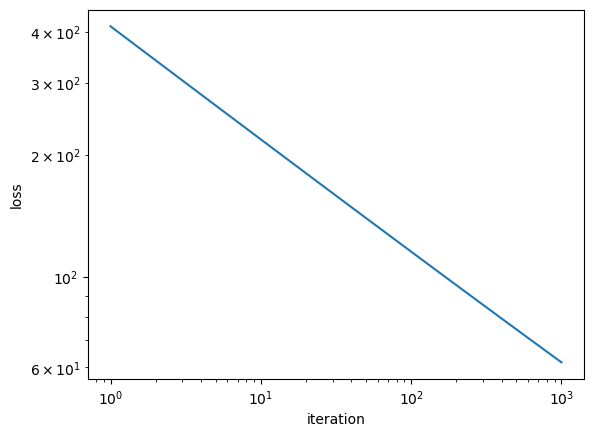

In [ ]:
from matplotlib import pyplot as plt

plt.plot(noised_encoding,y)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.yscale('log')
plt.xscale('log')
plt.show()